# ROOT

## Imports

In [1]:
# Loading Data & Functions #
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping array manipulation
import cv2                          # for image loading and colour conversion
import tensorflow as tf             # for bulk image resize
import glob
import random
import keras
from sklearn import discriminant_analysis
from sklearn import decomposition
from sklearn.decomposition import IncrementalPCA
import numpy
from sklearn.manifold import TSNE
import tensorflow as tf             # for bulk image resize
import keras

from keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, MaxPool2D, SpatialDropout2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import random
import copy

# import preprocessing.py as pre
from sklearn.model_selection import train_test_split


## Utility Functions

### FilePaths

In [2]:
path = './Processed_Images_Square/'
filename_list = './filenames/master.txt'

### Augmentation

In [3]:
import albumentations as A
def augment_data(img):
    # Define the augmentation pipeline
    augmentation = A.Compose([
        A.RandomBrightness(limit=(-0.3, 0.3), p=0.5)  # Adjust brightness
    ])

    # Apply augmentation
    augmented_img = augmentation(image=img)['image']

    return augmented_img

### Load Data

In [4]:
import os
import cv2

imgSize = 250

def load_data(fp, path, init_batch, batch):
    
     # find all images in the directory
    x = []
    y = []
    breedCount = {}
    
    with open(fp, "r") as file:
    # Read and process each line
        for f in file:
           
            # Strip the newline character and print the line
            dog_num = int(f.strip().split('_')[0])
            
            if dog_num not in breedCount:
                breedCount[dog_num] = 1
            else:
                breedCount[dog_num] += 1
            
            if not (breedCount[dog_num] > init_batch and breedCount[dog_num] <= batch):
                continue

            if(not os.path.isfile(path + f.strip())):
                print(f.strip(), os.path.isfile(path + f.strip()))
                continue
            # Process the file
            
            img = cv2.imread(path + f.strip())
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, (imgSize, imgSize))  # Resize the image to 224x224
            x.append(img / 255.0)  # Normalize pixel values to [0, 1] range
            y.append(dog_num)
            


    return np.array(x), np.array(y)


### Generatising

In [5]:
def vectorise(images):
    # use numpy's reshape to vectorise the data
    return np.reshape(images, [len(images), -1])


def plot_images(images, labels):
    fig = plt.figure(figsize=[15, 18])
    loop_count = 50
    if len(images) < 50:
        loop_count = len(images)
    for i in range(loop_count):
        ax = fig.add_subplot(8, 6, i + 1)
        ax.imshow(images[i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title(labels[i])
        ax.axis('off')


def get_siamese_data(batch_size):

    while True:
        files = glob.glob(path + '*.jpg')

        images = []
        labels = []

        for i in range(int(batch_size / 2)):
            ## Get original dog

            f = random.choice(files)
            original_dog = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) / 255.0


            ## Get matching pair
            f = f.split('/')[-1]
            dog_num = f.split('_')[0]

            matching_breed_files = glob.glob(path + dog_num + '*.jpg')
            matching_breed_files_without_original = copy.deepcopy(matching_breed_files)
            matching_breed_files_without_original.remove(path + f)

            matching_dog = random.choice(matching_breed_files)
            pair_dog = cv2.cvtColor(cv2.imread(matching_dog), cv2.COLOR_BGR2RGB) / 255.0

            images.append((original_dog, pair_dog))
            labels.append(1.0)

            ## Get non-matching pair
            non_matching_breed_files = [x for x in files if x not in matching_breed_files]

            non_matching_dog = random.choice(non_matching_breed_files)
            non_pair_dog = cv2.cvtColor(cv2.imread(non_matching_dog), cv2.COLOR_BGR2RGB) / 255.0

            images.append((original_dog, non_pair_dog))
            labels.append(0.0)


        yield np.array(images), np.array(labels)


def plot_pairs(x, y):
    fig = plt.figure(figsize=[25, 6])
    for i in range(10):
        ax = fig.add_subplot(2, 10, i*2 + 1)
        ax.imshow(x[i][0,:])
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))

        ax = fig.add_subplot(2, 10, i*2 + 2)
        ax.imshow(x[i][1,:])
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))



def plot_tsne(data_x, data_y):
    tsne_embeddings = TSNE(random_state=4).fit_transform(data_x)
    fig = plt.figure(figsize=[12, 12])
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = data_y.flatten());


def cmc_to_top(cmc, verbose=True):
    top1 = cmc[0]
    top5 = cmc[4]
    top10 = cmc[9]

    if verbose:
        print(f'Top 1: {top1}')
        print(f'Top 5: {top5}')
        print(f'Top 10: {top10}')

    return top1, top5, top10


# THE DATA

## Print All Data Samples

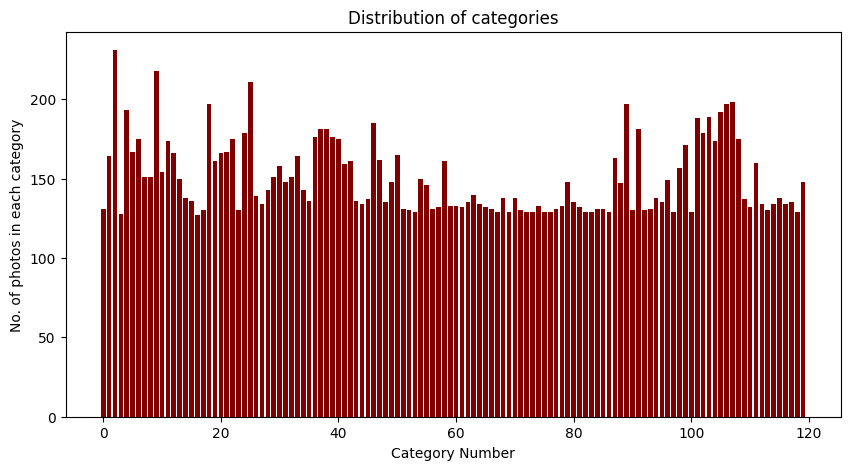

{0: 131,
 1: 164,
 2: 231,
 3: 128,
 4: 193,
 5: 167,
 6: 175,
 7: 151,
 8: 151,
 9: 218,
 10: 154,
 11: 174,
 12: 166,
 13: 150,
 14: 138,
 15: 136,
 16: 127,
 17: 130,
 18: 197,
 19: 161,
 20: 166,
 21: 167,
 22: 175,
 23: 130,
 24: 179,
 25: 211,
 26: 139,
 27: 134,
 28: 143,
 29: 151,
 30: 158,
 31: 148,
 32: 151,
 33: 164,
 34: 143,
 35: 136,
 36: 176,
 37: 181,
 38: 181,
 39: 176,
 40: 175,
 41: 159,
 42: 161,
 43: 136,
 44: 134,
 45: 137,
 46: 185,
 47: 162,
 48: 135,
 49: 148,
 50: 165,
 51: 131,
 52: 130,
 53: 129,
 54: 150,
 55: 146,
 56: 131,
 57: 132,
 58: 161,
 59: 133,
 60: 133,
 61: 132,
 62: 135,
 63: 140,
 64: 134,
 65: 132,
 66: 131,
 67: 129,
 68: 138,
 69: 129,
 70: 138,
 71: 130,
 72: 129,
 73: 129,
 74: 133,
 75: 129,
 76: 129,
 77: 131,
 78: 133,
 79: 148,
 80: 135,
 81: 132,
 82: 129,
 83: 129,
 84: 131,
 85: 131,
 86: 129,
 87: 163,
 88: 147,
 89: 197,
 90: 130,
 91: 181,
 92: 130,
 93: 131,
 94: 138,
 95: 135,
 96: 149,
 97: 129,
 98: 157,
 99: 171,
 100: 129,

In [6]:
import numpy
import matplotlib.pyplot as plt  

def count_categories():
    fp = "./filenames/train.txt"

    categories = {}

    with open(fp, "r") as file:
    # Read and process each line
        for f in file:
            if not f.startswith('.DS'):

                cat_num = int(f.split('_')[0])

                if cat_num not in categories:
                    categories[cat_num] = 1
                else:
                    categories[cat_num] += 1


    y = numpy.zeros(len(categories))

    for x in categories:
        y[x] = categories[x]

    x = list(range(len(y)))



    fig = plt.figure(figsize = (10, 5))
 
    # creating the bar plot
    plt.bar(x, y, color ='maroon')
    
    plt.xlabel("Category Number")
    plt.ylabel("No. of photos in each category")
    plt.title("Distribution of categories")
    plt.show()

    return categories

count_categories()

## Load Images

In [6]:
train_X, train_Y = load_data("./filenames/train.txt", "./train/",0, 30)

In [7]:
print(train_X.shape)

(3600, 250, 250, 3)


In [9]:
test_X, test_Y = load_data("./filenames/test.txt", "./test/",0,20)

In [9]:
print(test_X.shape)

(2280, 250, 250, 3)


# TRAINING

## PCA

### Eval Function

In [13]:
def get_ranked_histogram_l1_distance(gallery_feat, gallery_Y, probe_feat, probe_Y, verbose = False):
    
    # storage for ranked histogram
    # length equal to number of unique subjects in the gallery
    ranked_histogram = np.zeros(len(np.unique(gallery_Y)))

    # loop over all samples in the probe set
    for i in range(len(probe_Y)):
        # get the true ID of this sample
        true_ID = probe_Y[i]
        if verbose:
            print('Searching for ID %d' % (true_ID))

        # get the distance between the current probe and the whole gallery, L1 distance here. Note that L1
        # may not always be the best choice, so consider your distance metric given your problem
        dist = np.linalg.norm(gallery_feat - probe_feat[i,:], axis=1, ord=1)
        if verbose:
            print(dist)

        # get the sorted order of the distances
        a = np.argsort(dist)
        # apply the order to the gallery IDs, such that the first ID in the list is the closest, the second
        # ID is the second closest, and so on
        ranked = gallery_Y[a]
        if verbose:
            print('Ranked IDs for query:')
            print(a)

        # find the location of the True Match in the ranked list
        ranked_result = np.where(ranked == true_ID)[0][0]
        if verbose:
            print(ranked_result)

        # store the ranking result in the histogram
        ranked_histogram[ranked_result] += 1
        if verbose:
            print('')
    
    if verbose:
        print(ranked_histogram)
    
    return ranked_histogram

In [15]:

def ranked_hist_to_CMC(ranked_hist):

    cmc = np.zeros(len(ranked_hist))
    for i in range(len(ranked_hist)):
        cmc[i] = np.sum(ranked_hist[:(i + 1)])
    
    return (cmc / len(ranked_hist))

def plot_cmc(cmc):
    fig = plt.figure(figsize=[10, 8])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(1, len(cmc)+1), cmc)
    ax.set_xlabel('Rank')
    ax.set_ylabel('Count')
    ax.set_ylim([0, 1.0])
    ax.set_title('CMC Curve')  
    

### Main

In [11]:
pca = decomposition.IncrementalPCA()

batch_size = 40
train_Y = []

for i in range(2):
    train_X, train_y = load_data("./filenames/train.txt", "./train/",(i*batch_size), ((i+1)*batch_size))

    train_X_vec = vectorise(train_X)
    train_Y = np.concatenate((train_Y, train_y), axis=0)

    print(train_X_vec.shape)
    print(train_Y.shape)

    pca.partial_fit(train_X_vec)


print(np.shape(pca.components_))


(4800, 187500)
(4800,)


: 

## SVM

### Eval Functions

In [10]:
import time
from sklearn.svm import SVC

def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[100, 200])
    ax = fig.add_subplot(2, 1, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize=None, \
                                                 xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)), fontsize=100);
    ax = fig.add_subplot(2, 1, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize=None, \
                                                 xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)), fontsize=100);

### HOG

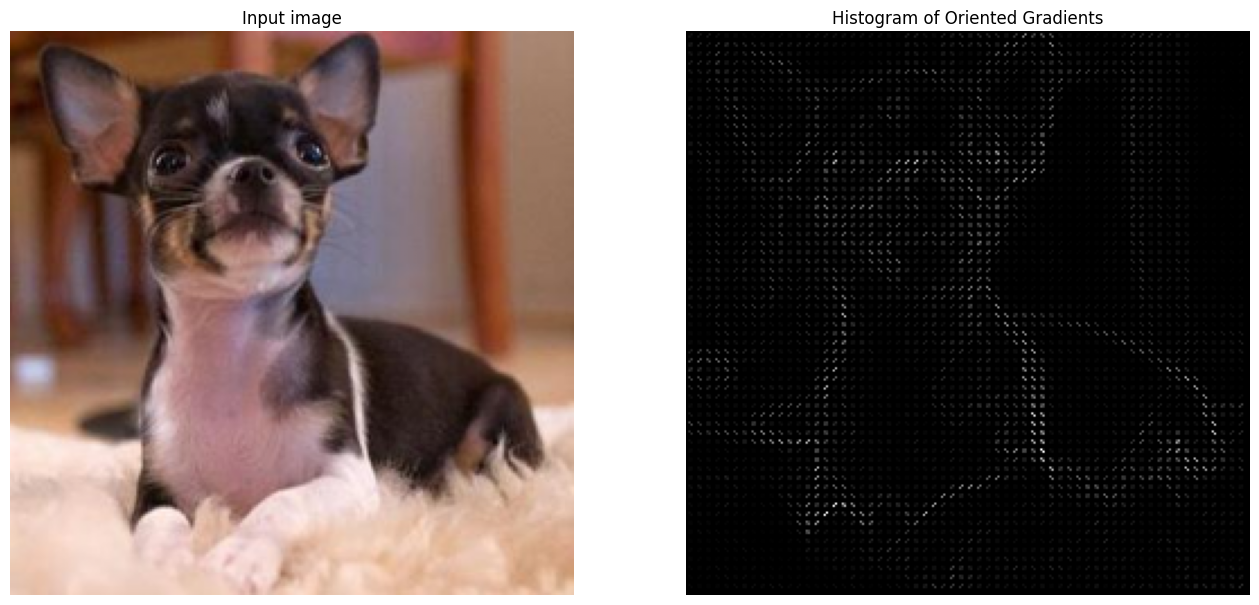

In [11]:
from skimage.feature import hog, local_binary_pattern
from skimage import data, exposure
from sklearn.metrics import ConfusionMatrixDisplay


fd, hog_image = hog(train_X[5,:,:,:], orientations=10, pixels_per_cell=(4,4),cells_per_block=(3,3), visualize=True, channel_axis=2)

# hog_image = backSub.apply(hog_image)
# display image and HOG representation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(train_X[5,:,:,:], cmap=plt.cm.gray)
ax1.set_title('Input image')
# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [12]:
# transform function
from skimage.feature import hog, local_binary_pattern
from skimage import data, exposure
from sklearn.metrics import ConfusionMatrixDisplay

def transform_datset_to_hog(data, orientations=10, pixels_per_cell=(4,4), cells_per_block=(3, 3)):
    hog_data = []
    for im in range(data.shape[0]):
        hog_data.append(hog(data[im, :, :, :], orientations=orientations, pixels_per_cell=pixels_per_cell,
                            cells_per_block=cells_per_block, visualize=False, channel_axis=2, feature_vector=True))
    return np.array(hog_data)



In [13]:
x_train_hog = transform_datset_to_hog(train_X)
x_test_hog = transform_datset_to_hog(test_X)

In [ ]:
from sklearn.model_selection import GridSearchCV
# RBF SVM. A good default option. Though with a feature dimension this high a Linear 
# SVM would also make a lot (if not more) sense.

param_grid = [
  {'C': [1000, 2000, 3000, 4000], 'kernel': ['linear']},
  {'C': [1000, 2000, 3000, 4000], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf']},
  {'C': [1000, 2000, 3000, 4000], 'degree': [1000, 2000, 3000, 4000], 'kernel': ['poly']},
 ]
svm = SVC(class_weight='balanced')
grid_search = GridSearchCV(svm, param_grid)
grid_search.fit(x_train_hog, train_Y)
grid_search.cv_results_

svm_start = time.process_time()
simple_svm = SVC(kernel='rbf').fit(x_train_hog, train_Y)
svm_train_end = time.process_time()
eval_model(simple_svm, x_train_hog, train_Y, x_test_hog, test_Y)
svm_eval_end = time.process_time()
print('The SVM with raw pixels took %d seconds to train and %d seconds to eval.' % \
      (svm_train_end - svm_start, svm_eval_end - svm_train_end))

## CKNN

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'n_neighbors' : [1, 8, 16, 32], 'weights': ['distance', 'uniform'], 'metric':['euclidean', 'seuclidean', 'dice', 'l1', 'sokalmichener', 'jaccard', 'l2', 'cityblock', 'russellrao', 'yule', 'sqeuclidean', 'mahalanobis', 'nan_euclidean', 'canberra', 'matching', 'manhattan', 'cosine', 'haversine', 'braycurtis', 'hamming', 'sokalsneath', 'minkowski', 'wminkowski', 'correlation', 'chebyshev', 'rogerstanimoto']}
 ]
cknn = KNeighborsClassifier()

grid_search = GridSearchCV(cknn, param_grid)
grid_search.fit(x_train_hog, train_Y)
grid_search.cv_results_

best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)
cknn = KNeighborsClassifier().set_params(**params)
cknn.fit(x_train_hog, train_Y)
eval_model(cknn, x_train_hog, train_Y, x_test_hog, test_Y)

: 

## Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()

param_grid = [
    {
        'n_estimators': [50, 100],
        # 'max_depth': [None, 10],
        # 'min_samples_split': [2, 10],
        # 'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
]

grid_search = GridSearchCV(rf, param_grid)
grid_search.fit(x_train_hog, train_Y)
grid_search.cv_results_

best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)
rf = RandomForestClassifier().set_params(**params)
rf.fit(x_train_hog, train_Y)
eval_model(rf, x_train_hog, train_Y, x_test_hog, test_Y)

: 